In [49]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
from IPython.display import HTML, display
from keras.models import load_model
from nutshell import ModelData, Learner, Representation

In [13]:
# Fathom concepts

# FactSet is a dataset with three columns: subject, fact_name, fact_value
#  
# You can generate a FactSet from a data with rows and columns using 
#  load_subject_rows: source dataframe has one row per subject - with columns containing fact values
#  load_fact_rows: source dataframe has many rows per subject - one row per fact name/value pair
#  results in internal fact_data dataset with one row per subject/fact



In [93]:
class FactSet:
    
    def __init__(self, factset_name):

        self.factset_name = factset_name  # this value informs the names of model files generated
        self.fact_data = pd.DataFrame()   # internal dataset with one row per subject/fact
        self.fact_alias_data = pd.DataFrame() #
        self.label_data = pd.DataFrame()  # internal dataset with one row per subject
        self.subject_column = ''          # name of subject id column in input dataset
        self.label_column = ''            # (optional) name label column - this will be not be used in training
        self.fact_name_column = ''        # name of fact name column in input dataset
        self.fact_value_column = ''       # name of fact value column in input dataset
        self.fact_alias_column = ''       # name of fact alias column in fact alias dataset
        self.fact_colnames = []           # optional: list of fact columns; default is all non subject/label columns
        self.fact_alias = {}              # a dictionary of dictionaries: outer is fact name, inner is fact value
        self.model = None
               
    def load_subject_rows(self, df):
        
        # dataset is in the format one row per subject, one fact per column
        print('Transposing data into fact rows...')
        
        #to do
        
    
    def load_fact_rows(self, df):
               
        # dataset is in the format one row per subject/fact, each row has a fact name and value column
        self.fact_data = pd.DataFrame()
        self.fact_data['subject'] = df[self.subject_column]
        self.fact_data['fact_name'] = df[self.fact_name_column]
        self.fact_data['fact_value'] = df[self.fact_value_column]
        
        print(len(df), 'fact rows loaded')
        
  
             

In [83]:
class Fathom:
    
    def __init__(self, factset):
        
        self.factset = factset
        self.model = None
        self.subject_representation = None
        self.subject_data = pd.DataFrame() # data for output for each subject
        self.fact_representation = None    
        self.fact_data = pd.DataFrame() # data for output for each fact
        self.embedding_factors = 5 # max number of factors in subject and fact embeddings - nutshell default is 50
             
       
    def load_model(self, p_model=None, modeldata=None, model_name=''):
        
        # load trained model and settings
 
        if p_model!=None:
            self.model = p_model
            md = modeldata
        else:
            if model_name=='':
                model_name = self.factset.factset_name
                
            self.model = load_model(model_name + '_model.h5')
            md = ModelData(self.factset_to_df, model_name + '_settings')

        # convert model embeddings to nutshell representation objects
        self.subject_representation = Representation(self.extract_embeddings('subject', md, include_key = True))
        self.fact_representation = Representation(self.extract_embeddings('fact', md, include_key = True))  
        
        # initialize output datasets
        self.subject_data = pd.DataFrame()
        self.subject_data['subject'] = self.subject_representation.keys
        self.fact_data = pd.DataFrame()
        self.fact_data['fact'] = self.fact_representation.keys
            
    
    def extract_embeddings(self, column_name, modeldata, include_key = False):
        
        embedding_list = self.model.get_layer('embed_' + column_name).get_weights()[0]
        
        if include_key:
            key_list = []
            for i in range(0, len(embedding_list)):
                v = modeldata.index_value[column_name][i]
                key_list.append(v)
            embedding_list = [embedding_list, key_list]
            return embedding_list
        else:
            return [embedding_list]
                   
            
    def factset_to_df(self):
        
        fact_data = self.factset.fact_data
        
        dfLearn = pd.DataFrame()        
        dfLearn['subject'] = fact_data['subject']
        dfLearn['fact'] = fact_data['fact_name'].astype('str') + '/' + fact_data['fact_value'].astype('str')
        dfLearn['is_true'] = 1
        
        return dfLearn
 
    
    def learn(self, batch_size=1024, super_epochs=1, epochs=1):
     
        # training a neural net to tell which facts are true and which are false about each subject
        #  so for every true fact about a subject, there should be an equal number of false facts
        #  false facts are taken from other subjects, so they are plausible facts       
        
        print('Preparing data for model training...')
    
        dfLearn = self.factset_to_df() # convert fact_data to training data format
        
        data = ModelData(dfLearn)        
        data.category_columns = ['subject','fact']
        data.label_column = 'is_true'
        data.prepare_data()
        data.add_false_rows(['subject']) # TODO: need to iterate to get rid of true facts labeled as false
        #data.prepare_data() # this wipes out false rows
        data.max_validation = 1 # overfitting is the point here - no need for validation set
        data.split_data(shuffle=True)       
        
        print('Building neural network...')
        
        model = Learner(data)

        #adjust embedding size based on configuration setting
        print('Embedding factors:', self.embedding_factors)
        #model.output_factors = self.embedding_factors # accuracy is substantially worse by reducing this value
        for c in model.category_factors.keys():
            model.category_factors[c] = self.embedding_factors
        
        model.dropout = .01 # overfitting is the point here - minimize dropout
        model.batch_size = batch_size
        model.build_model()
        
        print('Training neural network...')

        model.train_model(self.factset.factset_name, epochs=epochs, super_epochs=super_epochs, early_stopping='loss')
        # early_stopping='loss' is because we are trying to overfit - ignoring validation loss
        
        print ('Stored model to: ', self.factset.factset_name + '_', 'files')
        self.load_model(p_model=model.model, modeldata=data) # set internal model and extract embeddings
        
        
    def generate_xy(self, generate_for='subject'):
        
        # this will reduce embedding dimensions down to 2 x,y dimensions
        #  and add the x,y values to the output data set
        
        if generate_for == 'subject':
            g_representation = self.subject_representation
            g_data = self.subject_data
        else:
            generate_for = 'fact'
            g_representation= self.fact_representation
            g_data = self.fact_data
            
        print('Calculating x,y coordinates for ' + generate_for + 's (this could take a while)...')
        rep_2d = self.subject_representation.reduce_dimensions(2)
        g_data[generate_for + '_x'] = rep_2d[:,0]
        g_data[generate_for + '_y'] = rep_2d[:,1]
        print('Added ' + generate_for + '_x and ' + generate_for + '_y columns to ' + generate_for + '_data')
        
    def generate_clusters(self, cluster_count=5, generate_for='subject'):
        
        # this will create n clusters based on subject/fact embedding values
        #  and add the cluster_n value to the output data set
        # you can run this multiple times with different n values
        #  so multiple cluster sets can be added to the output to create super/sub clusters
        
        if generate_for == 'subject':
            g_representation = self.subject_representation
            g_data = self.subject_data
        else:
            generate_for = 'fact'
            g_representation= self.fact_representation
            g_data = self.fact_data
            
        print('Calculating ' + str(cluster_count) + ' subject clusters...')
        self.subject_representation.calculate_clusters(cluster_count)
        self.subject_data['cluster_' + str(cluster_count)] = self.subject_representation.clusters
        print('Added cluster_' + str(cluster_count) + ' to subject_data')
        
    def rename_cluster(self, generate_for='subject', cluster_count=5, old_cluster_name='', new_cluster_name=''):
        
        if old_cluster_name == '':
            raise Exception('You must provide a value for old_cluster_name parameter')
        if new_cluster_name=='':
            raise Exception('You must provide a string for new_cluster_name parameter')
            
        # TO DO find column, replace new value where old value is present
                    
    
    def contrast_cluster(self, cluster_count, cluster_name):
        
        # return a dataframe containing all unique facts for the subset of subjects 
        #  where the subset is equal to members of a cluster
        
        # join all facts from factset.fact_data and join to subject_data
        #  to apply subject cluster names to each fact
        
        print('Applying subject clusters to all facts in factset...')
        dfClusterFacts = pd.merge(self.factset.fact_data, \
                                  self.subject_data[['subject', 'cluster_'+str(cluster_count)]],\
                                 on='subject')
        
        print('Aggregating fact metrics for subjects in/out of cluster...')
        dfDescribe = self.contrast_subset(df=dfClusterFacts, col_name='cluster_'+str(cluster_count), col_value=cluster_name)
        
        return dfDescribe
        
    def contrast_subset(self, df, col_name, col_value):
        
        # return a dataframe containing metrics about all unique facts in factset
        #  for each fact, provide: in_subject_count, out_subject_count, in_fact_count, out_fact_count
        
        df['in_out'] = df[col_name].apply(lambda x: 'in' if str(x)==str(col_value) else 'out')
        dfFactInOut = df.groupby(['in_out', 'fact_name', 'fact_value']).subject.nunique().reset_index()
        dfFactInOut = dfFactInOut.rename(columns={"subject": "fact_subjects"})
        dfInOut = df.groupby(['in_out']).subject.nunique().reset_index()
        dfInOut = dfInOut.rename(columns={"subject": "set_subjects"})
        total_subjects = df.subject.nunique()
        dfFactMetrics = pd.merge(dfFactInOut, dfInOut, on='in_out').reset_index()
        dfFactMetrics['fact_perc'] = dfFactMetrics.apply(lambda x: x['fact_subjects'] / x['set_subjects'], axis=1)
        dfFactsIn = dfFactMetrics[dfFactMetrics['in_out']=='in'][['fact_name', 'fact_value', 'fact_subjects', 'set_subjects', 'fact_perc']]
        dfFactsIn = dfFactsIn.rename(columns={'fact_subjects':'in_fact_subjects', 'set_subjects':'in_subjects', 'fact_perc': 'in_fact_perc'})
        dfFactsOut = dfFactMetrics[dfFactMetrics['in_out']=='out'][['fact_name', 'fact_value', 'fact_subjects', 'set_subjects', 'fact_perc']]
        dfFactsOut = dfFactsOut.rename(columns={'fact_subjects':'out_fact_subjects', 'set_subjects':'out_subjects', 'fact_perc': 'out_fact_perc'})
        dfFactMetrics = pd.merge(dfFactsIn, dfFactsOut, on=['fact_name', 'fact_value'])

        dfFactMetrics['subject_diff'] = dfFactMetrics.apply(lambda x: x['in_fact_subjects'] - x['out_fact_subjects'], axis=1)
        dfFactMetrics['perc_diff'] = dfFactMetrics.apply(lambda x: (x['in_fact_perc'] - x['out_fact_perc'])/x['out_fact_perc'], axis=1)
        dfFactMetrics['total_subjects'] = total_subjects
        dfFactMetrics['in_subject_perc'] = dfFactMetrics.apply(lambda x: x['in_subjects'] / x['total_subjects'], axis=1)        
        
        return dfFactMetrics
 
    def describe_contrast(self, dfContrast, min_subjects=10, min_perc=.05):
        
        # display intreseting stats about the subset/cluster
        
        print('set contains', dfContrast['in_subjects'][0], 'of', dfContrast['total_subjects'][0],\
              'subjects', dfContrast['in_subject_perc'][0]*100, '%')

        if len(self.factset.fact_alias_data)>0:
            alias_column = self.factset.fact_alias_column
            dfContrast = pd.merge(dfContrast, \
                                  self.factset.fact_alias_data[['fact_name','fact_value',alias_column]], on=['fact_name','fact_value'])
            dfContrast['fact_value'] = dfContrast[alias_column]
            
        disp_cols = ['fact_name', 'fact_value', 'in_fact_subjects', 'in_fact_perc', 'out_fact_perc','perc_diff', 'subject_diff']

        dictFormats = {'in_fact_perc':'{:.2%}'.format, 'out_fact_perc':'{:.2%}'.format, 'perc_diff':'{:.2%}'.format}
        dfContrastHighFilter = dfContrast[(dfContrast['in_fact_subjects']>=min_subjects) & (dfContrast['in_fact_perc']>=min_perc)][disp_cols]
        dfContrastLowFilter = dfContrast[(dfContrast['out_fact_subjects']>=min_subjects) & (dfContrast['out_fact_perc']>=min_perc)][disp_cols]

        print('\nhigh concentration')
        display(HTML(dfContrastHighFilter.sort_values(by='subject_diff', ascending=False)[0:10].to_html(index=False, formatters=dictFormats)))
        print('\nlow concentration')
        display(HTML(dfContrastLowFilter.sort_values(by='subject_diff', ascending=True)[0:10].to_html(index=False, formatters=dictFormats)))

    
    def plot_clusters(self, cluster_count, generate_for='subject', max_points=500, cluster_name=''):
        
        # plot a small graph showing a sample of subjects/facts with dots colored by cluster
        
        if generate_for == 'subject':
            g_data = self.subject_data
        else:
            generate_for = 'fact'
            g_data = self.fact_data
            
        if cluster_name > '':
            g_data = g_data[g_data['cluster_'+str(cluster_count)].astype(str)==cluster_name]
            
        cl = g_data[0:max_points]['cluster_' + str(cluster_count)]
        plt.scatter(g_data[0:max_points]['subject_x'], g_data[0:max_points]['subject_y'], c=cl)

        plt.xlabel('reduced dimension x')
        plt.ylabel('reduced dimension y')

        #fig, ax = plt.subplots()
        #ax.legend()

        plt.show()        
        
               

In [16]:
# as a sample, use instacart purchases
# we will use users as subjects and products purchased as facts

dataPath = '/Users/Miles/Documents/Datasets/Instacart/'
dfProducts = pd.read_csv(dataPath + 'products.csv')
dfOrders = pd.read_csv(dataPath + 'orders.csv')
dfOrderProducts = pd.read_csv(dataPath + 'order_products__prior.csv')

In [17]:
# full set has 206K unique users
dfOrders['user_id'].nunique()

# take a random sample of 10K users - that is more managable
# also appears it takes more epochs to train the model, the more users there are :(
dfSample = pd.DataFrame()
dfSample['user_id'] = dfOrders['user_id'].unique()
dfSample = dfSample.sample(n=10000)

dfOrders = pd.merge(dfSample, dfOrders, on='user_id').reset_index()

In [18]:
# create list of user ids and products they have ordered

dfUserProducts = pd.merge(dfOrders, dfOrderProducts, on='order_id')[['user_id', 'product_id']].\
    sort_values(['user_id', 'product_id']).groupby(['user_id', 'product_id']).count().reset_index()

In [19]:
dfUserProducts['fact_name'] = 'product'

In [9]:
import csv
dfUserProducts.to_csv('grocery_userproducts.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)

In [21]:
dfUserProducts = pd.read_csv('grocery_userproducts.csv')

In [22]:
facts = FactSet('grocery')
facts.subject_column = 'user_id'
facts.fact_name_column = 'fact_name'
facts.fact_value_column = 'product_id'
facts.load_fact_rows(dfUserProducts)

649061 fact rows loaded


In [84]:
fathom = Fathom(facts)
#fathom.embedding_factors=10
#fathom.learn(super_epochs=3, epochs=15, batch_size=8192)
fathom.load_model(model_name='grocery')

In [85]:
# set product name alias
dataPath = '/Users/Miles/Documents/Datasets/Instacart/'
dfProducts = pd.read_csv(dataPath + 'products.csv')
dfProducts['fact_name'] = 'product'
fathom.factset.fact_alias_data = dfProducts.rename(columns={'product_id': 'fact_value'})[['fact_name', 'fact_value', 'product_name']]
fathom.factset.fact_alias_column = 'product_name'

In [29]:
fathom.generate_clusters(cluster_count=5)
fathom.generate_xy()
#fathom.subject_data = dfxy

Calculating 5 subject clusters...
Added cluster_5 to subject_data
Calculating x,y coordinates for subjects (this could take a while)...
Added subject_x and subject_y columns to subject_data


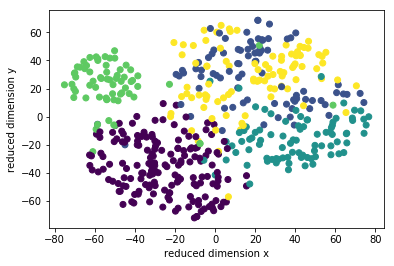

  subject  cluster_5  subject_x  subject_y
0   <pad>          2   5.512166 -17.845591
1   <unk>          0  -0.511980  -5.632832
2  196610          3 -44.378006  36.689072
3   32775          1  38.429996   5.697025
4   32776          1  47.208458   5.678079
5      13          1 -44.944530 -20.119377
6  163854          2  10.343383 -25.582529
7   32783          0 -24.056696 -35.655563
8  196624          3 -46.533016  16.914726
9   65558          0 -31.466858 -12.712247


In [30]:
fathom.plot_clusters(cluster_count=5)
print(fathom.subject_data[0:10])

In [42]:
dfxy = fathom.subject_data.copy()

In [109]:
fathom.describe_contrast(dfContrast)
# cluster 0
# high: chicken breasts, beans, garlic, onion tomato paste - cooking dinner
# low: no organic fruit

set contains 2703 of 10000 subjects 27.03 %

high concentration


fact_name,product_name,in_fact_subjects,in_fact_perc,out_fact_perc,perc_diff,subject_diff
product,Boneless Skinless Chicken Breasts,617,22.83%,3.00%,660.57%,398
product,No Salt Added Black Beans,410,15.17%,2.00%,658.10%,264
product,Cucumber Kirby,868,32.11%,8.63%,271.94%,238
product,Grated Parmesan,558,20.64%,4.43%,366.37%,235
product,Feta Cheese Crumbles,442,16.35%,2.99%,447.35%,224
product,Unsalted Butter,486,17.98%,3.60%,398.86%,223
product,Organic Garlic,942,34.85%,10.11%,244.58%,204
product,Organic Red Onion,732,27.08%,7.40%,265.94%,192
product,Shredded Parmesan,410,15.17%,3.01%,403.11%,190
product,Organic Tomato Paste,339,12.54%,2.04%,514.20%,190



low concentration


fact_name,product_name,in_fact_subjects,in_fact_perc,out_fact_perc,perc_diff,subject_diff
product,Bag of Organic Bananas,925,34.22%,30.00%,14.08%,-1264
product,Banana,1395,51.61%,31.08%,66.05%,-873
product,Strawberries,719,26.60%,18.99%,40.04%,-667
product,Organic Strawberries,1098,40.62%,23.46%,73.14%,-614
product,Organic Blueberries,650,24.05%,15.65%,53.65%,-492
product,Organic Raspberries,530,19.61%,13.76%,42.51%,-474
product,100% Whole Wheat Bread,166,6.14%,8.62%,-28.75%,-463
product,Organic Lemon,459,16.98%,12.05%,40.97%,-420
product,Creamy Peanut Butter,12,0.44%,5.89%,-92.47%,-418
product,Blueberries,381,14.10%,10.35%,36.23%,-374


In [112]:
fathom.describe_contrast(dfContrast)
# cluster 1
# high: bagels, eggs, nutella, waffles - cooking breakfast
# low: no veggies

set contains 1647 of 10000 subjects 16.47 %

high concentration


fact_name,product_name,in_fact_subjects,in_fact_perc,out_fact_perc,perc_diff,subject_diff
product,Fresh CA Grown Eggs,96,5.83%,0.08%,6855.40%,89
product,Coke Classic,106,6.44%,0.95%,580.50%,27
product,Plain Pre-Sliced Bagels,85,5.16%,0.83%,524.77%,16
product,Shredded Sharp Cheddar Cheese,99,6.01%,1.15%,423.01%,3
product,Fridge Pack Cola,143,8.68%,1.68%,418.03%,3
product,Natural Sharp Cheddar Sliced Cheese,91,5.53%,1.07%,418.56%,2
product,Hazelnut Spread With Skim Milk & Cocoa,87,5.28%,1.05%,401.40%,-1
product,"Cage Free Brown Eggs-Large, Grade A",116,7.04%,1.47%,378.30%,-7
product,Eggo Homestyle Waffles,86,5.22%,1.14%,359.12%,-9
product,Cola,83,5.04%,1.14%,343.10%,-12



low concentration


fact_name,product_name,in_fact_subjects,in_fact_perc,out_fact_perc,perc_diff,subject_diff
product,Bag of Organic Bananas,191,11.60%,34.99%,-66.86%,-2732
product,Organic Baby Spinach,32,1.94%,31.90%,-93.91%,-2633
product,Organic Strawberries,115,6.98%,32.26%,-78.36%,-2580
product,Banana,616,37.40%,36.48%,2.53%,-2431
product,Organic Hass Avocado,70,4.25%,24.46%,-82.62%,-1973
product,Large Lemon,178,10.81%,24.47%,-55.83%,-1866
product,Organic Avocado,122,7.41%,23.51%,-68.50%,-1842
product,Limes,180,10.93%,23.64%,-53.78%,-1795
product,Organic Garlic,6,0.36%,20.04%,-98.18%,-1668
product,Organic Yellow Onion,33,2.00%,20.12%,-90.04%,-1648


In [115]:
fathom.describe_contrast(dfContrast)
# cluster 2
# high: pita chips, cucumbers, trail mix, kale salad mix, yogurt, granola bars - active on the go
# low: fruits and veggies

set contains 1099 of 10000 subjects 10.99 %

high concentration


fact_name,product_name,in_fact_subjects,in_fact_perc,out_fact_perc,perc_diff,subject_diff
product,Clementines,282,25.66%,0.62%,4052.67%,227
product,Organic Simply Naked Pita Chips,156,14.19%,0.02%,63073.61%,154
product,Baby Cucumbers,139,12.65%,0.03%,37426.21%,136
product,Seedless Cucumbers,154,14.01%,0.31%,4354.55%,126
product,Trail Mix,129,11.74%,0.06%,20795.89%,124
product,Sweet Kale Salad Mix,144,13.10%,0.26%,4970.79%,121
product,Rainbow Bell Peppers,145,13.19%,0.34%,3814.60%,115
product,0% Greek Strained Yogurt,111,10.10%,0.01%,89800.91%,110
product,Crunchy Oats 'n Honey Granola Bars,119,10.83%,0.15%,7313.87%,106
product,Cherrios Honey Nut,112,10.19%,0.15%,6877.76%,99



low concentration


fact_name,product_name,in_fact_subjects,in_fact_perc,out_fact_perc,perc_diff,subject_diff
product,Banana,10,0.91%,41.04%,-97.78%,-3643
product,Organic Strawberries,217,19.75%,29.13%,-32.22%,-2376
product,Organic Baby Spinach,212,19.29%,27.92%,-30.90%,-2273
product,Large Lemon,5,0.45%,24.91%,-98.17%,-2212
product,Bag of Organic Bananas,456,41.49%,29.86%,38.95%,-2202
product,Organic Hass Avocado,2,0.18%,23.72%,-99.23%,-2109
product,Organic Avocado,3,0.27%,23.40%,-98.83%,-2080
product,Strawberries,257,23.38%,20.76%,12.63%,-1591
product,Organic Zucchini,2,0.18%,17.83%,-98.98%,-1585
product,Cucumber Kirby,2,0.18%,16.81%,-98.92%,-1494


In [118]:
fathom.describe_contrast(dfContrast)
# cluster 3
#high: lemon, broccoli, coconut water, string cheese, eggs, milk - yoga mom
#low: produce

set contains 2749 of 10000 subjects 27.49 %

high concentration


fact_name,product_name,in_fact_subjects,in_fact_perc,out_fact_perc,perc_diff,subject_diff
product,Organic Lemon,740,26.92%,8.25%,226.40%,142
product,Organic Broccoli Crowns,199,7.24%,0.95%,660.72%,130
product,100% Raw Coconut Water,266,9.68%,2.32%,317.63%,98
product,Organic Whole String Cheese,399,14.51%,4.25%,241.70%,91
product,Organic Extra Large Grade AA Brown Eggs,138,5.02%,0.65%,674.47%,91
product,Organic Green Seedless Grapes,263,9.57%,2.41%,296.41%,88
product,Organic Large Grade AA Brown Eggs,177,6.44%,1.39%,362.25%,76
product,Organic Large Brown Grade AA Cage Free Eggs,231,8.40%,2.21%,280.82%,71
product,Organic Bartlett Pear,307,11.17%,3.28%,240.24%,69
product,Organic Milk,166,6.04%,1.37%,342.28%,67



low concentration


fact_name,product_name,in_fact_subjects,in_fact_perc,out_fact_perc,perc_diff,subject_diff
product,Banana,878,31.94%,38.41%,-16.84%,-1907
product,Large Lemon,501,18.22%,23.73%,-23.21%,-1220
product,Strawberries,447,16.26%,22.87%,-28.89%,-1211
product,Limes,624,22.70%,21.11%,7.51%,-907
product,Cucumber Kirby,302,10.99%,16.49%,-33.40%,-894
product,Organic Avocado,607,22.08%,20.40%,8.25%,-872
product,Yellow Onions,299,10.88%,15.16%,-28.24%,-800
product,Blueberries,181,6.58%,13.17%,-50.01%,-774
product,Red Onion,104,3.78%,11.42%,-66.87%,-724
product,Organic Baby Spinach,998,36.30%,23.43%,54.94%,-701


In [121]:
fathom.describe_contrast(dfContrast)
# cluster 4
#high: hummus, yam, eggs, cream cheese, whole grain cereal, beans, tortillas - high protein
# low: spinach, avacodos, bananas

set contains 1802 of 10000 subjects 18.02 %

high concentration


fact_name,product_name,in_fact_subjects,in_fact_perc,out_fact_perc,perc_diff,subject_diff
product,Classic Hummus,201,11.15%,1.28%,770.88%,96
product,Sweet Potato Yam,101,5.60%,0.52%,968.58%,58
product,Grade A Large White Eggs,137,7.60%,0.98%,679.08%,57
product,Whole Grain Oat Cereal,97,5.38%,0.76%,611.76%,35
product,Philadelphia Original Cream Cheese,126,6.99%,1.12%,523.07%,34
product,Black Beans,186,10.32%,1.87%,453.06%,33
product,White Corn Tortillas,98,5.44%,0.82%,565.43%,31
product,Squeeze Tomato Ketchup,133,7.38%,1.35%,445.11%,22
product,Original Whipped Cream Cheese,121,6.71%,1.21%,456.04%,22
product,Super Soft Taco Flour Tortillas,99,5.49%,0.99%,456.04%,18



low concentration


fact_name,product_name,in_fact_subjects,in_fact_perc,out_fact_perc,perc_diff,subject_diff
product,Bag of Organic Bananas,270,14.98%,34.69%,-56.81%,-2574
product,Organic Baby Spinach,71,3.94%,32.03%,-87.70%,-2555
product,Organic Strawberries,221,12.26%,31.58%,-61.17%,-2368
product,Banana,764,42.40%,35.36%,19.89%,-2135
product,Organic Hass Avocado,116,6.44%,24.36%,-73.57%,-1881
product,Organic Garlic,16,0.89%,20.30%,-95.63%,-1648
product,Organic Avocado,244,13.54%,22.47%,-39.74%,-1598
product,Limes,307,17.04%,22.54%,-24.42%,-1541
product,Organic Yellow Onion,121,6.71%,19.43%,-65.44%,-1472
product,Large Lemon,450,24.97%,21.62%,15.53%,-1322


In [92]:
# describe individual embedding factors

factor_index = 6
#fathom=self

# break all subjects into two segments/bins, by high and low factor values 
dfBin = pd.DataFrame()
dfBin['subject'] = fathom.subject_representation.keys[2:]
dfBin['factor_value'] = fathom.subject_representation.vectors[2:,factor_index]
dfBin['factor_bin'] = pd.qcut(dfBin['factor_value'], 2, labels=False)

# contrast all subject facts using these high/low bins
dfBinFacts = pd.merge(fathom.factset.fact_data, \
                                  dfBin[['subject', 'factor_bin']],\
                                 on='subject')

dfContrastHigh = fathom.contrast_subset(dfBinFacts, col_name='factor_bin', col_value=1) # bin 1 = high values
fathom.describe_contrast(dfContrastHigh, min_subjects=10, min_perc=.05)

#dfContrastLow = fathom.contrast_subset(dfBinFacts, col_name='factor_bin', col_value=0) # bin 0 = low values
#fathom.describe_contrast(dfContrastLow, min_subjects=10, min_perc=.05)
  


set contains 5000 of 10000 subjects 50.0 %

high concentration


fact_name,fact_value,in_fact_subjects,in_fact_perc,out_fact_perc,perc_diff,subject_diff
product,Large Lemon,1519,30.38%,14.06%,116.07%,816
product,Limes,1474,29.48%,13.62%,116.45%,793
product,Organic Garlic,1236,24.72%,8.88%,178.38%,792
product,Organic Baby Spinach,1727,34.54%,19.40%,78.04%,757
product,Organic Avocado,1405,28.10%,13.62%,106.31%,724
product,Yellow Onions,1042,20.84%,7.12%,192.70%,686
product,Organic Zucchini,1130,22.60%,9.18%,146.19%,671
product,Organic Red Onion,958,19.16%,6.28%,205.10%,644
product,Cucumber Kirby,1070,21.40%,8.56%,150.00%,642
product,Carrots,949,18.98%,6.60%,187.58%,619



low concentration


fact_name,fact_value,in_fact_subjects,in_fact_perc,out_fact_perc,perc_diff,subject_diff
product,Clementines,30,0.60%,6.14%,-90.23%,-277
product,Soda,65,1.30%,6.36%,-79.56%,-253
product,Creamy Peanut Butter,131,2.62%,6.22%,-57.88%,-180
product,Hass Avocados,230,4.60%,8.02%,-42.64%,-171
product,Blackberries,144,2.88%,5.10%,-43.53%,-111
product,Raspberries,379,7.58%,9.38%,-19.19%,-90
product,Original Orange Juice,180,3.60%,5.28%,-31.82%,-84
product,Romaine Hearts,212,4.24%,5.68%,-25.35%,-72
product,Organic Reduced Fat 2% Milk,199,3.98%,5.08%,-21.65%,-55
product,Spring Water,231,4.62%,5.46%,-15.38%,-42
